# Model training

## Imports

In [2]:
import pandas as pd
import numpy as np
import random

import xgboost as xgb

import matplotlib.pyplot as plt
from matplotlib import cm, colors
from matplotlib import patches as mpatches
from mpl_toolkits.basemap import Basemap

import seaborn as sns

import os, sys

import sklearn
from sklearn.utils import shuffle
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error

import pickle

## Data paths

In [3]:
# Value to change to get correct paths
data_path = '../data/'

In [8]:
inputs_path = data_path + 'inputs/'
intermediate_path = data_path + 'intermediate/'
output_path = data_path + 'outputs/with_irrig/'

base_path = inputs_path + 'Base/'
diet_path = inputs_path + 'diet/'
pop_path = inputs_path + 'population/'

data_2000_path = intermediate_path + 'Baseline_df_iterations/with_irrig/'

data_2050_path = intermediate_path + 'Future_dfs/All_change+irrig/'
data_2050_gdp_cont_path = data_2050_path + 'gdp_cont/original/'
data_2050_gdp_stat_path = data_2050_path + 'gdp_cat_stat/original/'


model_output_path = output_path + 'model_output/'
composite_path = output_path + 'composite/'
compare_path = output_path + 'compare/'

model_path = data_path + 'models/'

In [9]:
numerical_col = ['log_slope', 'Annual Mean Temperature',
               'Mean Diurnal Range', 'Isothermality', 'Temperature Seasonality',
               'Max Temperature of Warmest Month', 'Min Temperature of Coldest Month',
               'Temperature Annual Range', 'Annual Precipitation',
               'Precipitation of Wettest Month', 'Precipitation of Driest Month',
               'Precipitation Seasonality', 'fertl_c3ann', 'fertl_c3nfx',
               'fertl_c3per', 'fertl_c4ann', 'log_altitude', 'irrig_c3ann', 
               'irrig_c3per', 'irrig_c3nfx', 'irrig_c4ann', 'irrig_c4per']

non_numerical_col = ['nutrient_availability_index', 'oxygen_availability_index',
               'workability_index', 'protected_areas_index', 'nutrient_retention_index', 
               'toxicity_index', 'excess_salts_index', 'rooting_conditions_index', 'cat_gdp']

In [10]:
files_2050 = os.listdir(data_2050_gdp_cont_path)
files_2050 = [filename for filename in files_2050 if 'ssp' in filename]

climate_models, climate_scenarios = [], []

for file in files_2050:
    if len(file) == 11:
        climate_models.append(file[:2])
        climate_scenarios.append(file[3:7])

climate_models = list(set(climate_models))
climate_models.sort()
climate_scenarios = list(set(climate_scenarios))
climate_scenarios.sort()
climate_models, climate_scenarios

(['cc', 'gs', 'he', 'mr'], ['ssp1', 'ssp2', 'ssp3', 'ssp4', 'ssp5'])

## Tune model

In [10]:
df_2000 = pd.read_csv(data_2000_path + 'normalized_2000_gdp_cat_new.csv', index_col='pixel_id')

In [14]:
len(df_2000)

906770

In [15]:
df_2000.head()

,slope,Annual Mean Temperature,Mean Diurnal Range,Isothermality,Temperature Seasonality,Max Temperature of Warmest Month,Min Temperature of Coldest Month,Temperature Annual Range,Annual Precipitation,Precipitation of Wettest Month,...,nutrient_availability_index,oxygen_availability_index,workability_index,protected_areas_index,nutrient_retention_index,toxicity_index,excess_salts_index,rooting_conditions_index,cat_gdp,calories_per_ha
pixel_id,,,,,,,,,,,,,,,,,,,,,
1272549,-0.153686,-1.475497,-1.165186,-1.144281,0.809341,-1.712443,-1.131726,0.526905,-0.529328,-0.764668,...,3.0,4.0,1.0,2,2.0,1.0,1.0,1.0,3,8.917904e+09
1276867,-0.044311,-1.450093,-1.237776,-1.168411,0.799235,-1.697998,-1.119308,0.518887,-0.542167,-0.789142,...,3.0,4.0,1.0,0,2.0,1.0,1.0,1.0,3,8.917904e+09
1276868,-0.064612,-1.451896,-1.224768,-1.167575,0.812007,-1.682255,-1.121053,0.529160,-0.552153,-0.780984,...,3.0,3.0,1.0,0,3.0,1.0,1.0,1.0,3,8.917905e+09
1298466,-0.029986,-1.373057,-1.550443,-1.245204,0.779111,-1.614412,-0.995392,0.407722,-0.629187,-0.797301,...,3.0,4.0,1.0,2,2.0,1.0,1.0,1.0,3,8.917906e+09
1298467,-0.027755,-1.386652,-1.462573,-1.218038,0.766754,-1.639893,-1.020766,0.426180,-0.619201,-0.789142,...,3.0,3.0,1.0,0,2.0,1.0,1.0,1.0,3,8.917904e+09


### Tune parameters

In [6]:
model_name = 'xgb_grid_search'

In [16]:
X, y = df_2000.drop(['calories_per_ha'], axis=1), df_2000['calories_per_ha']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=123)
eval_set = [(X_train, y_train), (X_test, y_test)]

In [17]:
parameters = {'booster': ['gbtree'],
              'objective': ['reg:squarederror'],
              'n_estimators': [500],
              'learning_rate': [0.01, 0.1, 0.5], 
              'min_split_loss': [0, 0.05, 0.1],
              'max_depth': [5, 10, 15],
              'min_child_weight': [1, 100, 500],
              'subsample': [0.2, 0.5, 1], 
              'colsample_bytree': [0.2, 0.5, 1], 
              'reg_alpha': [0.01, 0.1, 0.5]}

In [25]:
xgb_grid = GridSearchCV(xgb.XGBRegressor(),
                        parameters1,
                        scoring=['r2', 'neg_mean_squared_log_error'],
                        refit='r2',
                        n_jobs=-1,
                        cv=5, 
                        verbose=2)

In [ ]:
pd.DataFrame.from_dict(xgb_grid.cv_results_)

In [33]:
# Optimal parameters from gridsearch
optimal_params = {'booster': 'gbtree',
 'colsample_bytree': 0.5,
 'learning_rate': 0.05,
 'max_depth': 15,
 'min_child_weight': 1,
 'n_estimators': 500,
 'objective': 'reg:squarederror',
 'reg_alpha': 0.5}

### Train with best parameters

In [19]:
df_2000 = pd.read_csv(data_2000_path + 'normalized_2000_gdp_cat_new.csv', index_col='pixel_id')

In [8]:
# Optimal parameters from gridsearch
optimal_params = {'booster': 'gbtree',
 'colsample_bytree': 0.5,
 'learning_rate': 0.05,
 'max_depth': 15,
 'min_child_weight': 1,
 'n_estimators': 500,
 'objective': 'reg:squarederror',
 'reg_alpha': 0.5}

In [9]:
model_name = 'final_new_param_train'

In [20]:
X, y = df_2000.drop(['calories_per_ha', 'label_10'], axis=1), df_2000['calories_per_ha']
X = pd.get_dummies(X, columns=non_numerical_col)

In [21]:
col_order = X.columns

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=123)
eval_set = [(X_train, y_train), (X_test, y_test)]

In [23]:
try:
    model = pickle.load(open(model_path + model_name + '.sav', 'rb'))
except: 
    model = xgb.XGBRegressor(**optimal_params)
    model.fit(X_train, y_train, early_stopping_rounds=10, eval_metric=["rmse"], eval_set=eval_set, verbose=True)
    #pickle.dump(model, open(model_path + model_name + '.sav', 'wb'))

In [24]:
# make predictions for test data
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred)**(1/2)
print(f'R2 score: {r2}')
print(f'RMSE: {rmse}')

R2 score: 0.9458864367747841
RMSE: 1060810492.7417127


In [25]:
# retrieve performance metrics
results = model.evals_result()
epochs = len(results['validation_0']['rmse'])
x_axis = range(0, epochs)
epochs

500

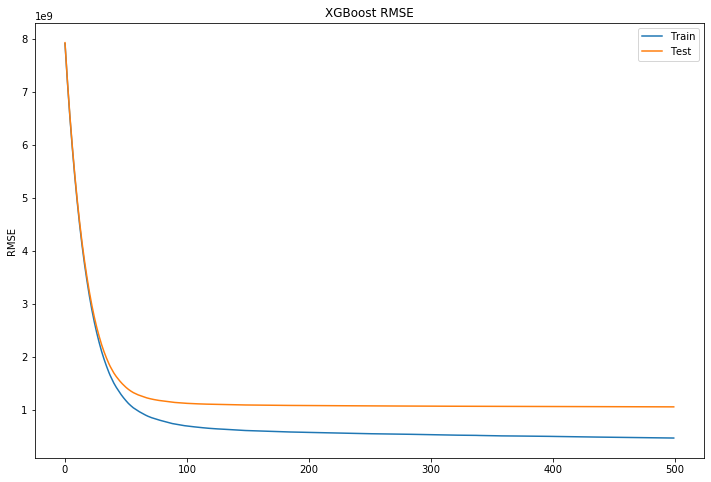

In [26]:
# plot mse
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(x_axis, results['validation_0']['rmse'], label='Train')
ax.plot(x_axis, results['validation_1']['rmse'], label='Test')
ax.legend()
plt.ylabel('RMSE')
plt.title('XGBoost RMSE')
plt.show()

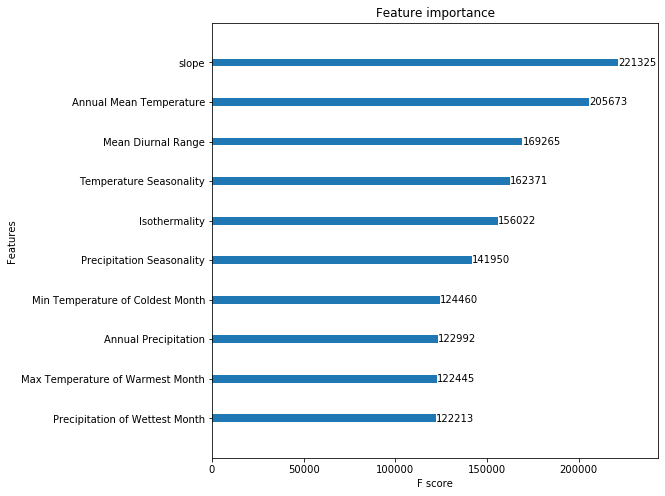

In [32]:
# which are the most influential features
fig, ax = plt.subplots(figsize=(8, 8))
xgb.plot_importance(model, max_num_features=10, ax=ax, grid=False, title='Feature importance')

### Final model

We take the model with calories (not log(calories)) as our final model, this model performing better than the one using the log(calories).

In [35]:
# Optimal parameters from gridsearch
optimal_params = {'booster': 'gbtree',
 'colsample_bytree': 0.5,
 'learning_rate': 0.05,
 'max_depth': 15,
 'min_child_weight': 1,
 'n_estimators': 500,
 'objective': 'reg:squarederror',
 'reg_alpha': 0.5}

In [36]:
model_name = 'final_model_no_log.sav'

In [37]:
df_2000 = pd.read_csv(data_2000_path + 'normalized_2000_gdp_cat_new.csv', index_col='pixel_id').drop(['label_10'], axis=1)

In [43]:
X = pd.get_dummies(df_2000.drop(['calories_per_ha'], axis=1), columns=non_numerical_col)

In [44]:
col_order = X.columns

In [40]:
try:
    model = pickle.load(open(model_path + model_name + '.sav', 'rb'))
except: 
    model = xgb.XGBRegressor(**optimal_params)
    model.fit(X_train, y_train, early_stopping_rounds=10, eval_metric=["rmse"], eval_set=eval_set, verbose=True)
    #pickle.dump(model, open(model_path + model_name + '.sav', 'wb'))

## Future predictions

### Predict scenarios

In [84]:
model_name = 'final_model_no_log'
model = pickle.load(open(model_path + model_name + '.sav', 'rb'))

In [86]:
col_order = model.get_booster().feature_names

In [11]:
non_numerical_col_2 = non_numerical_col.copy()
non_numerical_col_2.remove('cat_gdp')

In [88]:
for climate_model in climate_models:
    print(climate_model)
    for ssp in climate_scenarios:
        print(ssp)
        print('Loading data')
        df = pd.read_csv(data_2050_gdp_stat_path + 'model_input_{}_{}_gdp_cat_stat.csv'.format(climate_model, ssp)).drop(['log_GDP_pc'], axis=1)
        
        df = pd.get_dummies(df, columns=non_numerical_col)
        
        missing_col = [col for col in col_order if col not in df.columns]
        for col in missing_col:
            print(col)
            df[col] = 0
        
        print('Predicting future yields')
        df['calories_per_ha'] = model.predict(df[col_order])
        print('Saving output')
        #df.to_csv(model_output_path + '{}_{}_2050_new.csv'.format(climate_model, ssp))

cc
ssp1
Loading data
cat_gdp_1
Predicting future yields
Saving output
ssp2
Loading data
Predicting future yields
Saving output
ssp3
Loading data
Predicting future yields
Saving output
ssp4
Loading data
Predicting future yields
Saving output
ssp5
Loading data
cat_gdp_0
Predicting future yields
Saving output
gs
ssp1
Loading data
cat_gdp_1
Predicting future yields
Saving output
ssp2
Loading data
Predicting future yields
Saving output
ssp3
Loading data
Predicting future yields
Saving output
ssp4
Loading data
Predicting future yields
Saving output
ssp5
Loading data
cat_gdp_0
Predicting future yields
Saving output
he
ssp1
Loading data
cat_gdp_1
Predicting future yields
Saving output
ssp2
Loading data
Predicting future yields
Saving output
ssp3
Loading data
Predicting future yields
Saving output
ssp4
Loading data
Predicting future yields
Saving output
ssp5
Loading data
cat_gdp_0
Predicting future yields
Saving output
mr
ssp1
Loading data
cat_gdp_1
Predicting future yields
Saving output
ssp2
L

### Aggregate climate models

In [89]:
# Mean of yield on climate models
for ssp in climate_scenarios:
    print('Aggregating {}'.format(ssp))
    data = []
    for climate_model in climate_models:
        print('Reading {}'.format(climate_model))
        df = pd.read_csv(model_output_path + '{}_{}_2050_new.csv'.format(climate_model, ssp), index_col='pixel_id', na_values=[-9999])
        data.append(df['calories_per_ha'])
    
    output_df = pd.concat(data, axis=1).mean(axis=1)
    #output_df.to_csv(composite_path + '{}_composite_2050_new.csv'.format(ssp), header=['calories_per_ha'], index=True)

Aggregating ssp1
Reading cc


/Users/Romain/anaconda3/envs/food_sufficiency/lib/python3.8/site-packages/numpy/lib/arraysetops.py:568: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Reading gs
Reading he
Reading mr
Aggregating ssp2
Reading cc
Reading gs
Reading he
Reading mr
Aggregating ssp3
Reading cc
Reading gs
Reading he
Reading mr
Aggregating ssp4
Reading cc
Reading gs
Reading he
Reading mr
Aggregating ssp5
Reading cc
Reading gs
Reading he
Reading mr


### Put everything together

In [46]:
df_2000 = pd.read_csv(data_2000_path + 'normalized_2000_gdp_cat_new.csv', index_col='pixel_id')

In [27]:
def predictions_df_future(y_predicted, cropland_serie_2000, cropland_serie_2050, change_cols=True):
    
    compare = pd.concat([cropland_serie_2000.rename('%cropland_2000'), 
                         cropland_serie_2050.rename('%cropland_2050'),
                         y_predicted.rename('cal_per_ha_pred')], axis=1)
            
        
    compare = compare.merge(pd.DataFrame(df_2000['calories_per_ha']),
                            how='outer',
                            right_index=True, 
                            left_index=True)
    
    compare  = compare.rename({'calories_per_ha':'cal_per_ha_2000'}, axis=1)
    
    # Add data points with positive 2000 yields but not in 2050 as points with 0 value yields
    points_2000 = compare['cal_per_ha_2000'].dropna().index
    points_2050 = compare['cal_per_ha_pred'].dropna().index

    in_2000_not_in_2050 = [i for i in points_2000 if i not in points_2050]
    print('disappering cropland', len(in_2000_not_in_2050))
    compare.loc[in_2000_not_in_2050, 'cal_per_ha_pred'] = 0
    
    if change_cols == True:
        compare['delta_cal_per_ha'] = compare['cal_per_ha_pred'] - compare['cal_per_ha_2000']

        compare['%delta_cal_per_ha'] = (compare['cal_per_ha_pred'] - compare['cal_per_ha_2000']) / compare['cal_per_ha_2000']
    
    return compare

In [28]:
def compute_cal(cal_per_ha, nb_ha, cropland):
    return cal_per_ha * nb_ha * cropland

In [47]:
land_use_2000 = pd.read_csv(inputs_path + 'LU/' + 'Cropmask_lulc_esa_2000.csv', index_col='pixel_id')['%cropland']
ha_per_cell = pd.read_csv(inputs_path + 'LU/ha_per_cell.csv', index_col='pixel_id')
population_2000 = pd.read_csv(inputs_path + 'population/pop_2000.csv', index_col='pixel_id')['gpw_population'].rename('population_2000')
countries = pd.read_csv(base_path + 'country_ids.csv')
countries_names = pd.read_csv(base_path + 'country_names.csv', encoding='latin-1')
countries = countries[['country_id','pixel_id']].merge(countries_names[['base_id','ISO3','name', 'sovereignt']],right_on='base_id',left_on='country_id',how='right')
countries = countries.set_index('pixel_id')

for ssp in climate_scenarios:
        print(ssp)
        df = pd.read_csv(data_2050_gdp_stat_path + '{}_{}_gdp_cat_stat.csv'.format(climate_model, ssp), index_col='pixel_id', na_values=[-9999])
        land_use_2050 = df['%cropland']
        
        df_pred = pd.read_csv(composite_path + '{}_composite_2050_new.csv'.format(ssp), index_col='pixel_id', na_values=[-9999])
        output_df = predictions_df_future(df_pred['calories_per_ha'], land_use_2000, land_use_2050)
        
        population = pd.read_csv(inputs_path + 'population/pop_{}.csv'.format(ssp), index_col='pixel_id')['gpw_population'].rename('population_2050')
        
        joined_df = output_df.join([ha_per_cell, population_2000, population])
        
        joined_df['calories_2000'] = compute_cal(joined_df['cal_per_ha_2000'], joined_df['ha_per_pixel'], joined_df['%cropland_2000'])
        joined_df['calories_2050'] = compute_cal(joined_df['cal_per_ha_pred'], joined_df['ha_per_pixel'], joined_df['%cropland_2050'])
        
        joined_df['delta_cal'] = joined_df['calories_2050'] - joined_df['calories_2000']
        joined_df['%delta_cal'] = joined_df['delta_cal'] / joined_df['calories_2000']
        
        joined_df = joined_df.merge(countries, right_on='pixel_id', left_on='pixel_id')
        #joined_df.to_csv(compare_path + '{}_compare_new.csv'.format(ssp))

ssp1
ssp2
ssp3
ssp4
ssp5
